# Titre

In [67]:
import pandas as pd 
import os 
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.metrics import r2_score, mean_squared_error
import importlib
import modeles

importlib.reload(modeles)

from modeles import forecast_quality_oos, ar1_fit_predict, rolling_window_forecast
from modeles import har_fit_predict, garch_fit_predict, msar1_fit_predict
from modeles import expanding_window_forecast, mom_vol_target_weights
from modeles import rebalance_dates_mask, performance_metrics

## traitement des datas

In [68]:
data = pd.read_excel(r"C:\Users\user\Bureau\Projet_Ml_Momentum\data_v2.xlsx", sheet_name="target", skiprows=1)
data2 = pd.read_excel(r"C:\Users\user\Bureau\Projet_Ml_Momentum\data_v2.xlsx", sheet_name="features", skiprows=1)

In [69]:
target = data.iloc[:, 1:11].copy()
feat = data2.iloc[:, 1:30].copy()

target = target.set_index(target.columns[0])
feat = feat.set_index(feat.columns[0])

target.index = pd.to_datetime(target.index, format = "%Y%m%d").copy()

## analyse des datas

### Analyse des facteurs action

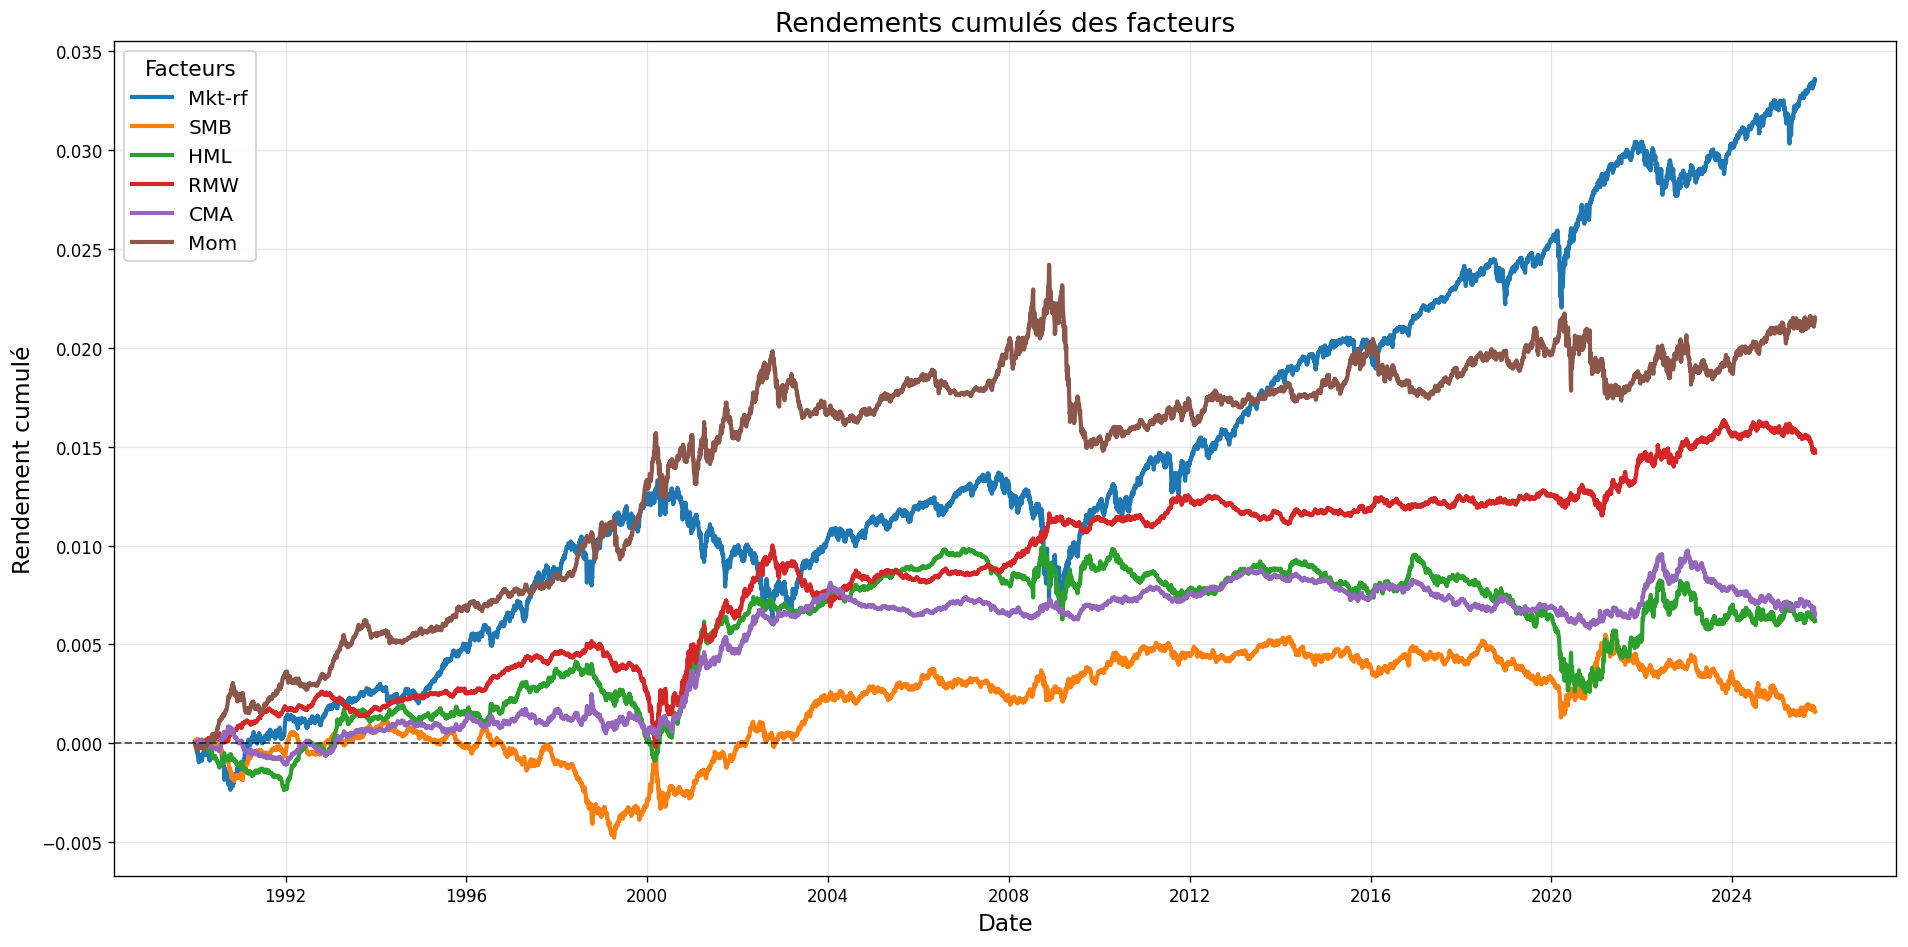

In [70]:

fact = target[["Mkt-rf", "SMB", "HML", "RMW", "CMA", "Mom"]].copy()
fact = fact/100
fact_cumsum = (fact.cumsum()/100).copy()

plt.figure(figsize=(16, 8), dpi=120)

for col in fact.columns:
    plt.plot(
        fact_cumsum.index,
        fact_cumsum[col],
        label=col,
        linewidth=2.5
    )

plt.axhline(
    0,
    linestyle="--",
    linewidth=1.2,
    color="black",
    alpha=0.6
)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rendement cumulé", fontsize=14)
plt.title("Rendements cumulés des facteurs", fontsize=16)

plt.legend(
    title="Facteurs",
    title_fontsize=13,
    fontsize=12,
    loc="upper left",
    frameon=True,
    framealpha=0.9
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Construction des variances réalisées

**Résulé des variables (pandas.Series):**

- ``r`` sont les rendements journaliers du facteur Momentum. Il y a 9026 observation. 

- ``rv_1``, ``rv_5``, ``rv_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées chaque jours, et contiennent respectivement 9026, 9022 et 9006 observations. Nous notons RV les variances réalisées. 

- ``log_rv_1``, ``log_rv_5`` et ``log_rv_21`` sont les RV ``rv_1``, ``rv_5`` et ``rv_21`` en logarithme. La transformation logarithmique est généralement préférée car la variance est très asymétrique, tandis que son logarithme est beaucoup plus proche d’une loi gaussienne et se prête mieux à des modèles linéaires. De plus, le passage en log transforme les chocs de volatilité — empiriquement multiplicatifs — en chocs additifs, ce qui améliore l’interprétation économique et les performances de prévision. Afin d’assurer la stabilité numérique lors du passage au logarithme, nous ajoutons une petite constante espilon à la variance réalisée.

- ``rv_j_1``, ``rv_h_5``, ``rv_m_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées à une fréquence journalière, hebdomadaire et mensuelle de manière à éviter *l'overlap*. En effet, si nous estimions par exemple des RV mensuelles chaque jours alors une grande partie de l'information contenue dans le cible serait présente dans les variables explicatives (*features*). Nous utilions ces RV pour les modèles AR. Elles contiennent respectivement 9026, 1805 et 429 observations. 

- ``log_rv_j_1``, ``log_rv_h_5`` et ``log_rv_m_21`` sont les RV ``rv_j_1``, ``rv_h_5`` et ``rv_m_21`` en logarithme. 

**Résulé des variables (pandas.DataFrame):**

- ``rv_m`` et ``log_rv_m`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence mensuelle. L'utilisation d'un DataFrame permet d'avoir des dates similaires pour les trois types de variance. Ils sont donc utilisées pour les modèles HAR mensuels. 

- ``rv_h`` et ``log_rv_h`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence hebdomadaire. Ils sont donc utilisées pour les modèles HAR hebdomadaires. 

- ``rv_m_as``, ``log_rv_m_as``, ``rv_h_as``, ``log_rv_h_as`` sont les mêmes DataFrames, avec des variables splémentaires, détaillées ci-dessous. Ils sont utilisées pour les HAR-RS, HAR-X, etc. 

In [71]:
# constante pour le passage au logarithme
eps = 1e-12

# Rendements journaliers en décimal
r = target["Mom"].copy() / 100.0

# Variances réalisées, fréquence journalière
rv_1  = r.pow(2).dropna()
rv_5  = r.pow(2).rolling(5).sum().dropna()
rv_21 = r.pow(2).rolling(21).sum().dropna()

# Variances réalisées en logarithme, fréquence journalière
log_rv_21 = np.log(rv_21 + eps)
log_rv_5 = np.log(rv_5 + eps)
log_rv_1 = np.log(rv_1 + eps)

# Variances réalisées fréquence journalière, hebdomadaire et mensuelle
rv_j_1 = rv_1.copy().dropna()
rv_h_5 = rv_5.copy().iloc[::5].dropna()
rv_m_21 = rv_21.copy().iloc[::21].dropna()

# Variances réalisées en logarithme, fréquence journalière, hebdomadaire et mensuelle
log_rv_m_21 = np.log(rv_m_21 + eps)
log_rv_h_5 = np.log(rv_h_5 + eps)
log_rv_j_1 = np.log(rv_j_1 + eps)

**Données pour les HAR :**

Nous regroupons dans un dataframe la série de variance mensuelle à fréquence mensuelle, ainsi que les variances hebdomadaire et journalière. De cette manière nous ne retenons que les dates de la variance mensuelle pour les variances hebdomadaires et journalières afin d'utiliser ce DataFrame pour les HAR mensuels. Il y a 429 observations. Nous créeons également un dataframe basé sur la même méthode à fréquence hebdomadaire, dans lequel il y a 1801 observations. Et enfin nous créeons un dataframe basé sur la même méthode à fréquence journalière avec 9006 observations. 

In [72]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence mensuelle
rv_m = rv_m_21.to_frame("RV 21j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_m = rv_m.join(rv_1.to_frame("RV 1j"), how = "left")

log_rv_m = np.log(rv_m + eps)


In [73]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_h = rv_h_5.to_frame("RV 5j").join(rv_21.to_frame("RV 21j"), how = "left")
rv_h = rv_h.join(rv_1.to_frame("RV 1j"), how = "left")
rv_h = rv_h.dropna()

log_rv_h = np.log(rv_h + eps)

In [74]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_j = rv_1.to_frame("RV 1j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_j = rv_j.join(rv_21.to_frame("RV 21j"), how = "left")
rv_j = rv_j.dropna()

log_rv_j = np.log(rv_j + eps)

**Données pour les LHAR :**

Nous enrichissons les variables HAR en ajoutant des semi-variances réalisées négatives et une mesure d’asymétrie (« jump »), définie comme la différence entre la variance associée aux rendements positifs et négatifs, afin de capturer les effets asymétriques de la volatilité. 

In [75]:
# Nous initialisons un DataFrame avec les rendements et la variance journalière
r = target["Mom"].copy() / 100.0
r_asym = pd.concat([r, rv_1], axis = 1)
r_asym.columns = ["r", "rv_1"]

# Décomposition asymétrique de la variance en fonction du signe du rendement
r_asym["rv1_pos"] = np.where(r_asym["r"]>0,r_asym["rv_1"], 0)
r_asym["rv1_neg"] = np.where(r_asym["r"]<0,r_asym["rv_1"], 0)

# Construction des variables asymétriques journalières, hebdomadaires et mensuelles
rv_j_1_pos = r_asym["rv1_pos"]
rv_j_1_neg = r_asym["rv1_neg"]
rv_h_5_pos  = r_asym["rv1_pos"].rolling(5).sum().dropna()
rv_h_5_neg  = r_asym["rv1_neg"].rolling(5).sum().dropna()
rv_m_21_neg = r_asym["rv1_neg"].rolling(21).sum().dropna()
rv_m_21_pos = r_asym["rv1_pos"].rolling(21).sum().dropna()
 
# Mesure d'asymétrie (jump) : différence entre variance positive et négative
jump_m = rv_m_21_pos - rv_m_21_neg
jump_h = rv_h_5_pos - rv_h_5_neg
jump_j = rv_j_1_pos - rv_j_1_neg

# On renomme pour les DataFrames
rv_j_1_neg= rv_j_1_neg.rename("RV1_neg")
rv_h_5_neg= rv_h_5_neg.rename("RV5_neg")
rv_m_21_neg= rv_m_21_neg.rename("RV21_neg")
jump_j = jump_j.rename("Jump_j")
jump_h = jump_h.rename("Jump_h")
jump_m = jump_m.rename("Jump_m")

# Ajout des variables aux dataframes HAR journaliers
rv_j_as = rv_j.join(rv_j_1_neg, how = "left")
rv_j_as = rv_j_as.join(rv_h_5_neg, how = "left")
rv_j_as = rv_j_as.join(rv_m_21_neg, how = "left")
rv_j_as = rv_j_as.join(jump_j, how = "left")
rv_j_as = rv_j_as.join(jump_h, how = "left")
rv_j_as = rv_j_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR hebdomadaires
rv_h_as = rv_h.join(rv_j_1_neg, how = "left")
rv_h_as = rv_h_as.join(rv_h_5_neg, how = "left")
rv_h_as = rv_h_as.join(rv_m_21_neg, how = "left")
rv_h_as = rv_h_as.join(jump_j, how = "left")
rv_h_as = rv_h_as.join(jump_h, how = "left")
rv_h_as = rv_h_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR mensuels
rv_m_as = rv_m.join(rv_j_1_neg, how = "left")
rv_m_as = rv_m_as.join(rv_h_5_neg, how = "left")
rv_m_as = rv_m_as.join(rv_m_21_neg, how = "left")
rv_m_as = rv_m_as.join(jump_j, how = "left")
rv_m_as = rv_m_as.join(jump_h, how = "left")
rv_m_as = rv_m_as.join(jump_m, how = "left")

# colonnes à selectionner pour le logarithme (toutes sauf 'jump')
cols_log_j = rv_j_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_h = rv_h_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_m = rv_m_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])

# application du log uniquement sur ces colonnes
log_rv_j_as = rv_j_as.copy()
log_rv_h_as = rv_h_as.copy()
log_rv_m_as = rv_m_as.copy()
log_rv_j_as[cols_log_j] = np.log(rv_j_as[cols_log_j]+ eps)
log_rv_h_as[cols_log_h] = np.log(rv_h_as[cols_log_h]+ eps)
log_rv_m_as[cols_log_m] = np.log(rv_m_as[cols_log_m]+ eps)

print(log_rv_j_as)

                RV 1j     RV 5j    RV 21j    RV1_neg    RV5_neg  RV21_neg  \
Date                                                                        
1990-01-30  -9.952468 -9.633155 -8.058788  -9.952468  -9.640662 -8.320394   
1990-01-31 -12.639937 -9.688376 -8.502748 -27.631021  -9.750423 -8.972426   
1990-02-01 -10.442713 -9.308284 -8.410763 -27.631021  -9.750423 -9.051202   
1990-02-02 -10.637040 -9.129406 -8.356308 -27.631021  -9.863882 -9.155000   
1990-02-05 -13.142566 -9.152260 -8.398033 -13.142566  -9.912125 -9.250225   
...               ...       ...       ...        ...        ...       ...   
2025-10-27 -10.720385 -8.042731 -6.776885 -27.631021  -8.668656 -7.075251   
2025-10-28  -9.656627 -8.438243 -6.725259 -27.631021 -12.754254 -7.075251   
2025-10-29  -7.884964 -7.435558 -6.481390 -27.631021 -27.631021 -7.129787   
2025-10-30 -16.223445 -7.507357 -6.798354 -16.223445 -16.223445 -7.862735   
2025-10-31 -10.557029 -7.624069 -6.776367 -10.557029 -10.553575 -7.800281   

**Données pour le LHAR-X :**

Nous ajoutons la série VIX aux DataFrames pour le LHAR-X. 

In [76]:
feat = feat.copy().ffill()

log_rv_j_as = log_rv_j_as.join(feat["VIXCLS"],  how = "left") 
log_rv_h_as = log_rv_h_as.join(feat["VIXCLS"],  how = "left") 
log_rv_m_as = log_rv_m_as.join(feat["VIXCLS"],  how = "left") 

### Analyse des volatilitées

Nous calculons les volatilitées annualisées du facteur Momentum. 

In [92]:
# Volatilités annualisées
vol_1_ann  = np.sqrt(252 * rv_1)
vol_5_ann  = np.sqrt(252/5 * rv_5)
vol_21_ann = np.sqrt(252/21 * rv_21)

Nous représentons graphiquement la volatilité hebdomadaire annualisée ainsi que la performance cummulée du facteur Momentum. ²

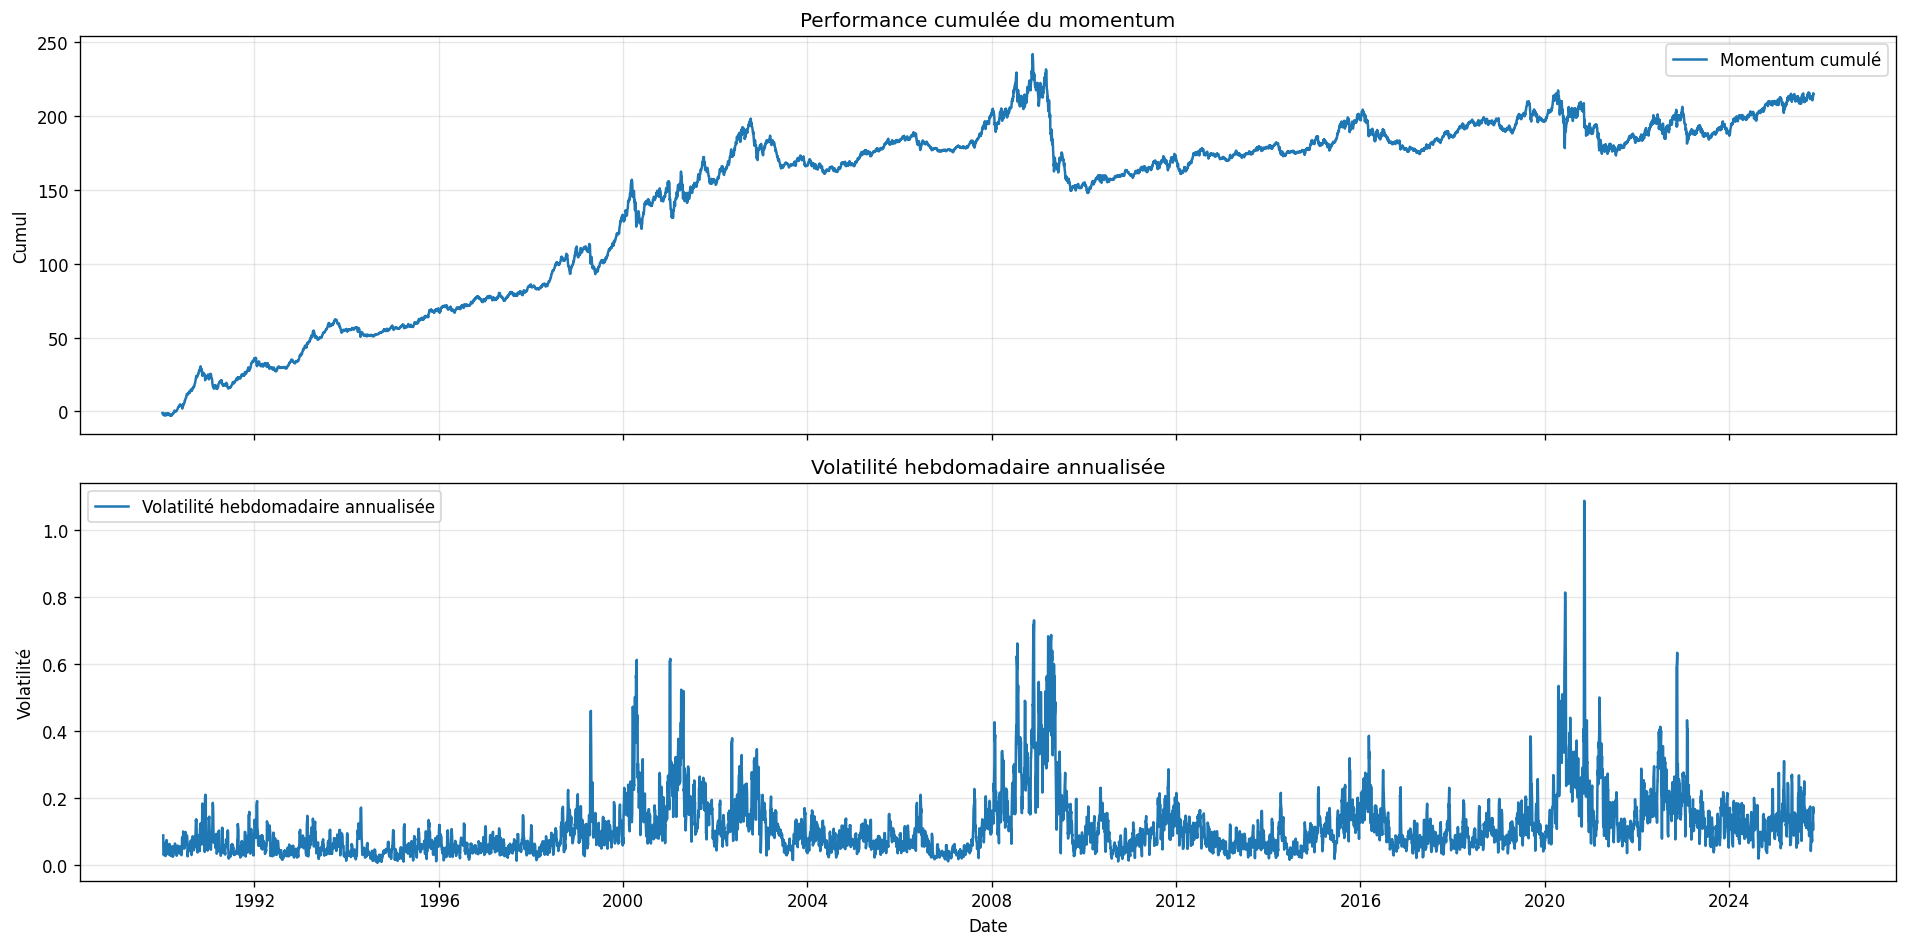

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), dpi=120, sharex=True)

# --- Graph 1 : cumul du momentum ---
mom_cum = target['Mom'].cumsum()
axes[0].plot(mom_cum.index, mom_cum, label="Momentum cumulé")
axes[0].set_title("Performance cumulée du momentum")
axes[0].set_ylabel("Cumul")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- Graph 2 : volatilité hebdomadaire annualisée ---
# (on trace avec l'index de vol_5_ann, pas data.index)
axes[1].plot(vol_5_ann.index, vol_5_ann, label="Volatilité hebdomadaire annualisée")
axes[1].set_title("Volatilité hebdomadaire annualisée")
axes[1].set_ylabel("Volatilité")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Pour éviter l'overlap nous construisons 3 séries : jours, hhebdo et mois 

test de RU

In [79]:
rv_m_t = rv_m_21.iloc[40:160]
print(len(rv_m_t))

120


In [80]:

# ADF avec constante
adf_c = adfuller(rv_m_t, regression="c", autolag="AIC")

# ADF avec constante + trend
adf_ct = adfuller(rv_m_t, regression="ct", autolag="AIC")

print("ADF (constante)")
print("  stat   :", adf_c[0])
print("  p-value:", adf_c[1])
print("  lags   :", adf_c[2])
print("  crit   :", adf_c[4])

print("\nADF (constante + trend)")
print("  stat   :", adf_ct[0])
print("  p-value:", adf_ct[1])
print("  lags   :", adf_ct[2])
print("  crit   :", adf_ct[4])


ADF (constante)
  stat   : -1.198559818805363
  p-value: 0.6742149344718269
  lags   : 12
  crit   : {'1%': np.float64(-3.492995948509562), '5%': np.float64(-2.888954648057252), '10%': np.float64(-2.58139291903223)}

ADF (constante + trend)
  stat   : -1.8620296926470115
  p-value: 0.6741088786562347
  lags   : 12
  crit   : {'1%': np.float64(-4.045970933273362), '5%': np.float64(-3.452348053635668), '10%': np.float64(-3.1515755794286404)}


## Prédiction de variance

### Random walk

In [81]:
log_rv21_rw_fcst = log_rv_m_21.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_m_21,
    y_pred=log_rv21_rw_fcst
)

print(oos_metrics)

log_rv5_rw_fcst = log_rv_h_5.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5,
    y_pred=log_rv5_rw_fcst
)

print(oos_metrics)

log_rv1_rw_fcst = log_rv_j_1.shift(1)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_j_1,
    y_pred=log_rv1_rw_fcst
)

print(oos_metrics)



N_OOS     428.000000
MSPE        0.486483
RMSE        0.697484
MAE         0.552857
R2_OOS      0.661583
dtype: float64
N_OOS     1804.000000
MSPE         1.097805
RMSE         1.047762
MAE          0.810964
R2_OOS       0.429197
dtype: float64
N_OOS     9025.000000
MSPE        11.653632
RMSE         3.413742
MAE          2.387617
R2_OOS      -0.587325
dtype: float64


**Prédiction hebdomadaire :**

### Modèles AR

**AR(1) mensuel** :

In [82]:
log_rv21_ar1_fcst = rolling_window_forecast(
    y=log_rv_m_21,
    fit_predict_fn=ar1_fit_predict,
    window=120,
)

# log_rv21_ar1_fcst = expanding_window_forecast(
#     y=log_rv_m_21,
#     fit_predict_fn=ar1_fit_predict,
#     min_window = 240,
# )

oos_metrics = forecast_quality_oos(
    y_true=log_rv_m_21,
    y_pred=log_rv21_ar1_fcst
)

print(oos_metrics)

N_OOS     309.000000
MSPE        0.461249
RMSE        0.679153
MAE         0.526668
R2_OOS      0.640043
dtype: float64


**AR(1) hebdomadaire** :

In [83]:
log_rv5_ar1_fcst = rolling_window_forecast(
    y=log_rv_h_5,
    fit_predict_fn=ar1_fit_predict,
    window=780,
)

log_rv5_ar1_fcst = expanding_window_forecast(
    y=log_rv_h_5,
    fit_predict_fn=ar1_fit_predict,
    min_window=780,
)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5,
    y_pred=log_rv5_ar1_fcst
)

print(oos_metrics)

N_OOS     1025.000000
MSPE         0.893976
RMSE         0.945503
MAE          0.741106
R2_OOS       0.498489
dtype: float64


In [84]:

log_rv1_ar1_fcst = rolling_window_forecast(
    y=log_rv_j_1,
    fit_predict_fn=ar1_fit_predict,
    window=2520,
)

log_rv1_ar1_fcst = expanding_window_forecast(
    y=log_rv_j_1,
    fit_predict_fn=ar1_fit_predict,
    min_window=1260,
)

oos_metrics = forecast_quality_oos(
    y_true=log_rv_j_1,
    y_pred=log_rv1_ar1_fcst
)

print(oos_metrics)

N_OOS     7766.000000
MSPE         7.150811
RMSE         2.674100
MAE          2.010503
R2_OOS       0.013482
dtype: float64


### modèles HAR :

**Modèles HAR mensuels :**

In [85]:
y_M = log_rv_m["RV 21j"]              # cible mensuelle
X_M = log_rv_m[["RV 1j", "RV 5j", "RV 21j"]]  # features (les trois variances)

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=240,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=240,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


N_OOS     189.000000
MSPE        0.416676
RMSE        0.645505
MAE         0.510405
R2_OOS      0.567011
dtype: float64


**Modèles HAR hebdomadaires :**

In [86]:
y_H = log_rv_h["RV 5j"]              # cible mensuelle
X_H = log_rv_h[["RV 1j", "RV 5j", "RV 21j"]]  # D, W, M

log_rv5_har_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520,
    X=X_H,
)

# log_rv5_har_fcst = expanding_window_forecast(
#     y=y_H,
#     fit_predict_fn=har_fit_predict,
#     min_window=780,
#     X=X_H,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_har_fcst
)

print(oos_metrics_har)


N_OOS     1281.000000
MSPE         0.723989
RMSE         0.850876
MAE          0.664835
R2_OOS       0.568439
dtype: float64


**Modèles HAR journaliers :**

In [87]:
y_J = log_rv_j["RV 1j"]       # cible journalière
X_J = log_rv_j[["RV 1j", "RV 5j", "RV 21j"]]  # features (les trois variances)

log_rv1_har_fcst = rolling_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    window=2520,
    X=X_J,
)

# log_rv1_har_fcst = expanding_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     min_window=1260,
#     X=X_J,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_har_fcst
)

print(oos_metrics_har)


N_OOS     6486.000000
MSPE         5.920126
RMSE         2.433131
MAE          1.733537
R2_OOS       0.161286
dtype: float64


### HARSJ

In [88]:
y_M = log_rv_m_as["RV 21j"]              # cible mensuelle
X_M = log_rv_m_as[["RV 1j", "RV 5j", "RV 21j", "RV21_neg", "Jump_m"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=120,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=240,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


N_OOS     309.000000
MSPE        0.449438
RMSE        0.670401
MAE         0.516433
R2_OOS      0.649260
dtype: float64


In [89]:
y_H = log_rv_h_as["RV 5j"]              # cible mensuelle
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h"]]  # D, W, M

log_rv5_lhar_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, #780 
    X=X_H
)

# log_rv5_lhar_fcst = expanding_window_forecast(
#     y=y_H,
#     fit_predict_fn=har_fit_predict,
#     min_window=780,
#     X=X_H,
# )

oos_metrics_lhar = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_lhar_fcst
)

print(oos_metrics_lhar)


N_OOS     1281.000000
MSPE         0.741557
RMSE         0.861137
MAE          0.666107
R2_OOS       0.557967
dtype: float64


In [90]:
y_J = log_rv_j_as["RV 1j"]              # cible mensuelle
X_J = log_rv_j_as[["RV 1j", "RV 5j", "RV 21j", "RV1_neg"]]   # D, W, M

log_rv1_lhar_fcst = rolling_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    window=2520,
    X=X_J
)

# log_rv1_lhar_fcst = expanding_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     min_window=2520,
#     X=X_J,
# )

oos_metrics_lhar = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_lhar_fcst
)

print(oos_metrics_lhar)

N_OOS     6486.000000
MSPE         5.921988
RMSE         2.433514
MAE          1.733026
R2_OOS       0.161023
dtype: float64


### HARSJ-X

In [91]:
y_M = log_rv_m_as["RV 21j"]              # cible mensuelle
X_M = log_rv_m_as[["RV 1j", "RV 5j", "RV 21j", "RV21_neg", "Jump_m", "DGS3MO"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv21_har_fcst = rolling_window_forecast(
    y=y_M,
    fit_predict_fn=har_fit_predict,
    window=240,
    X=X_M,
)

# log_rv21_har_fcst = expanding_window_forecast(
#     y=y_M,
#     fit_predict_fn=har_fit_predict,
#     min_window=120,
#     X=X_M,
# )

oos_metrics_har = forecast_quality_oos(
    y_true=y_M,
    y_pred=log_rv21_har_fcst
)

print(oos_metrics_har)


KeyError: "['DGS3MO'] not in index"

In [ ]:
y_H = log_rv_h_as["RV 5j"]              # cible mensuelle
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h", "VIXCLS"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv5_har_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, # 780 ou 520
    X=X_H,
)

log_rv5_har_fcst = expanding_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    min_window=780,
    X=X_H,
)

oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_har_fcst
)

print(oos_metrics_har)

N_OOS     1021.000000
MSPE         0.735855
RMSE         0.857820
MAE          0.671018
R2_OOS       0.587143
dtype: float64


In [ ]:
y_J = log_rv_j_as["RV 1j"]              # cible mensuelle
X_J = log_rv_j_as[["RV 1j", "RV 5j", "RV 21j", "RV1_neg", "VIXCLS"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

# log_rv1_har_fcst = rolling_window_forecast(
#     y=y_J,
#     fit_predict_fn=har_fit_predict,
#     window=1260, # 2520 ou 1260 
#     X=X_J,
# )

log_rv1_har_fcst = expanding_window_forecast(
    y=y_J,
    fit_predict_fn=har_fit_predict,
    min_window=2520,
    X=X_J,
)

oos_metrics_har = forecast_quality_oos(
    y_true=y_J,
    y_pred=log_rv1_har_fcst
)

print(oos_metrics_har)

N_OOS     6486.000000
MSPE         5.908092
RMSE         2.430657
MAE          1.754152
R2_OOS       0.162991
dtype: float64


### Modèles GARCH, GJR et EGARCH

**Prévision de variance mensuelle :**

In [ ]:
rv21_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, #2520 (10 ans) ou 5040 (20 ans)
    horizon = 21, 
    step = 21,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Zero", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv21_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =5040, #2520 (10 ans) ou 5040 (20 ans)
#     horizon = 21, 
#     step = 21, 
#     o = 1,  # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",       # GARCH ou EGARCH
#     dist = "t"   # t pour Student et normal pour normale
# )

eps = 1e-12
log_rv21_garch_fcst = np.log(rv21_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_21,
    y_pred=log_rv21_garch_fcst
)

print(oos_metrics_garch)


N_OOS     309.000000
MSPE        0.413375
RMSE        0.642942
MAE         0.520777
R2_OOS      0.677403
dtype: float64


**Prévision de variance hebdomadaire :**

In [ ]:
rv5_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =3780, #2520 (10 ans) ou 3780 (15 ans)
    horizon = 5, 
    step = 5,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Constant", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv5_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =2520, #2520 (10 ans) ou 3780 (15 ans)
#     horizon = 5, 
#     step = 5,
#     o = 1, # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",      # GARCH ou EGARCH
#     dist = "t"  # t pour Student et normal pour normale
#     )

eps = 1e-12
log_rv5_garch_fcst = np.log(rv5_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_5,
    y_pred=log_rv5_garch_fcst
)

print(oos_metrics_garch)


KeyboardInterrupt: 

**Prévision de variance journalière :**

In [ ]:
rv1_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, # 1260 (5ans) ou 2520 (10 ans) 
    horizon = 1, 
    step = 1,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Zero", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

# rv1_garch_fcst = expanding_window_forecast(
#     y=r,
#     fit_predict_fn=garch_fit_predict,
#     min_window =2520, # 1260 (5ans) ou 2520 (10 ans) 
#     horizon = 1, 
#     step = 1,
#     o = 1, # 1 pour le GJR, 0 sinon
#     mean = "Zero", # Zero ou Constant
#     vol="GARCH",      # GARCH ou EGARCH
#     dist = "normal"  # t pour Student et normal pour normale
#     )

eps = 1e-12
log_rv1_garch_fcst = np.log(rv1_garch_fcst + eps)

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_1,
    y_pred=log_rv1_garch_fcst
)

print(oos_metrics_garch)


N_OOS     6506.000000
MSPE         7.684872
RMSE         2.772160
MAE          1.841618
R2_OOS      -0.089678
dtype: float64


## Portefeuille


La fonction ``rebalance_dates_mask`` renvoie une Serie avec True aux dates rebalancement du portefeuille, en fonction de la fréquence que nous souhaitons et des jours de trading. 

### Benchmark

In [99]:
metrics_mom = performance_metrics(fact["Mom"])
metrics_CMA = performance_metrics(fact["CMA"])
metrics_mom = performance_metrics(fact["RMW"])
metrics_mom = performance_metrics(fact["HML"])
print(metrics_CMA)

Mean annual return    0.018217
Annual volatility     0.068775
Sharpe ratio          0.264884
Max drawdown         -0.285693
Skewness             -0.266540
Kurtosis              6.476706
Hit ratio             0.487148
dtype: float64


### Volatility targeting

In [97]:
rb = rebalance_dates_mask(log_rv21_rw_fcst, rebalance_freq="D")
print(rb)

Date
1990-03-01    True
1990-03-30    True
1990-05-01    True
1990-05-31    True
1990-06-29    True
              ... 
2025-06-09    True
2025-07-10    True
2025-08-08    True
2025-09-09    True
2025-10-08    True
Name: rebalance, Length: 428, dtype: bool


In [ ]:

weights = mom_vol_target_weights(
    log_var_mom_fcst=log_rv1_garch_fcst,
    rb=rb,
    target_vol_annual=0.10,
    w_max=2.0,
    no_trade_band= 0.05
)

In [ ]:
rp = (
    weights["w_mom"] * fact["Mom"]  # Mom
    + weights["w_def"] * fact["CMA"]
).dropna()

metrics = performance_metrics(rp)
print(metrics)

Mean annual return    0.069290
Annual volatility     0.109263
Sharpe ratio          0.634158
Max drawdown         -0.288631
Skewness             -0.530140
Kurtosis              2.678563
Hit ratio             0.539656
dtype: float64


In [ ]:
metrics = performance_metrics(fact["Mom"])
print(metrics)

Mean annual return     0.060004
Annual volatility      0.148918
Sharpe ratio           0.402934
Max drawdown          -0.632886
Skewness              -1.168474
Kurtosis              14.148641
Hit ratio              0.546865
dtype: float64
